Script de carga datos MySQL en cluster con Mongo

In [1]:
!pip install mysql-connector==2.1.7
!pip install pandas
!pip install sqlalchemy
#requiere instalación adicional, consultar https://github.com/PyMySQL/mysqlclient
!pip install mysqlclient
!pip install numpy
!pip install pymysql

In [52]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import numpy as np
import sqlalchemy
import time
import matplotlib.pyplot as plt
import random

from mysql.connector.cursor import MySQLCursor

In [3]:
#Los resultados de medidas de tiempo en carga por dominios se almacenan en estos objetos.
#Se itera durante 100 iteraciones para sacar medias
CustomerProfileDomainSchema_ds = []
PositionKeepingDomainSchema_ds = []
CurrentAccountDomainSchema_ds = []

#repeticiones
repeats = 100

In [4]:
#Borrado de la tabla antes de carga 
def prepare_table_for_load(entity):
    cursor = conn.cursor
    alter_table_q = 'ALTER TABLE {} AUTO_INCREMENT=0'.format(entity)
    delete_table_q = 'DELETE FROM {}'.format(entity)
    cursor.execute(alter_table_q)
    cursor.execute(delete_table_q)
    conn.commit()

In [5]:
#Deshabilitar y habilitar Foreing key (cargas masivas)
def set_foreing_key_mysql_value(value):
    cursor.execute('SET foreign_key_checks = {}'.format(value))

# CustomerProfileDomainSchema

In [6]:
conn = mysql.connector.connect(host='localhost',
                                    port=6446,
                                    database='CustomerProfileDomainSchema',
                                    user='root',                                       
                                    password='mysql')
if conn.is_connected():
        conn.autocommit = False #Apenas se observa diferencia de rendimiento
        print('Connected to MySQL database')
    
cursor = conn.cursor()  
    
def connection_open():
   
    #InnoDB Cluster
    conn = mysql.connector.connect(host='localhost',
                                    port=6446,
                                    database='CustomerProfileDomainSchema',
                                    user='root',                                       
                                    password='mysql')


    if conn.is_connected():
        conn.autocommit = False #Apenas se observa diferencia de rendimiento
        print('Connected to MySQL database')
    
    cursor = conn.cursor()  

Connected to MySQL database


In [7]:
CustomerProfile_csv_file = "../MockData/CustomerProfile.csv"
Address_csv_file = "../MockData/Address.csv"
Country_csv_file = "../MockData/Country.csv"

In [8]:
Country_df = pd.read_csv(Country_csv_file, header=[0])
Country_df['Code'] = Country_df["Code"]
Country_df

,CountryId,ShortName,Description,Code,Unnamed: 4
0,1,Spain,Omnis dolore id dicta consequatur sit omnis. E...,IND,NaN
1,2,USA,Id dolorem a soluta harum iusto qui repellat. ...,GBP,NaN
2,3,Greatbrit,Aut sapiente dicta illo consectetur nulla labo...,SPA,NaN


In [9]:
#TRATAMIENTO ENTIDAD ADDRESS
Address_df = pd.read_csv(Address_csv_file, header=[0])

del(Address_df['Unnamed: 9'])
Address_df['AddressType'] = Address_df["AddressType"].str[:3]
CountrySubDivisionList=['abc','def','hig']
Address_df['CountrySubDivision'] = np.resize(CountrySubDivisionList,len(Address_df))

Address_df['PostCode'] = Address_df['PostCode'].astype('string')
Address_df['CountrySubDivision'] = Address_df['CountrySubDivision'].astype('string')

#Generamos una función mas de 1M de registros basados en registros anteriores
def generate_new_values_by_samples(df,rango):
    for x in range(rango):
        df = df.append(df.sample(frac=0.50,replace = False))
    return df


Address_df = generate_new_values_by_samples(Address_df,9)

print(len(Address_df))
Address_df.sample(1)

12611


,PartyId,AddressType,AddressLine,StreetName,BuildingNumber,PostCode,TownName,CountrySubDivision,CountryId
190,6152,Sou,83420 Rico Fields,Maryjane Vista,71577,12918,East Gailbury,def,3


In [10]:
#TRATAMIENTO ENTIDAD CUSTOMER PROFILE

CustomerProfile_df = pd.read_csv(CustomerProfile_csv_file, header=[0])

#Indexado PartyId para mejor legibilidad
CustomerProfile_df['PartyId'].reset_index()
CustomerProfile_df['PartyId'] = CustomerProfile_df.index
CustomerProfile_df[CustomerProfile_df.columns[pd.Series(CustomerProfile_df.columns).str.startswith('Unnamed:')]]

#Limpieza de datos. Eliminamos el apostrofe del campo AccountRole y PartyType
CustomerProfile_df['AccountRole'] = CustomerProfile_df['AccountRole'].str.replace("'",'')
CustomerProfile_df['PartyType'] = CustomerProfile_df['PartyType'].str.replace("'",'')

#Phone y PArtyData debe ser truncado (error generacion FillDB)
CustomerProfile_df['Phone'] = CustomerProfile_df["Phone"].str[:10]
CustomerProfile_df['PartyType'] = CustomerProfile_df["PartyType"].str[:2]
BeneficialOwnerShipValues=[1,2,3,4,5,6,7]
CustomerProfile_df['BeneficialOwnership'] = np.resize(BeneficialOwnerShipValues,len(CustomerProfile_df))

print(len(CustomerProfile_df))
CustomerProfile_df.sample(1)

10000


,PartyId,PartyNumber,PartyType,Name,FullLegalName,LegalStructure,BeneficialOwnership,AccountRole,EmailAddress,Phone,Unnamed: 10
8136,8136,347.0,so,Florida,Araceli Greenfelder,Dr.,3,US.OBIE.Principal,theron.mclaughlin@example.net,1-420-329-,NaN


## ETL entidad country

In [11]:
Country_ETL_times = []

In [12]:
Country_Insert_query = 'INSERT INTO Country(ShortName,Description,Code) VALUES(%s, %s, %s)'

def load_country():
    time_inicial = time.time()
    for i,row in Country_df.iterrows():
        cursor.execute(Country_Insert_query,(row[1],row[2],row[3]))          
    time_final = time.time()
    Country_ETL_times.append(time_final - time_inicial)
    conn.commit() 
    return Country_ETL_times 

In [13]:
cursor = conn.cursor()
alter_table_q = """ALTER TABLE Country AUTO_INCREMENT=0"""
delete_table_q = """DELETE FROM Country"""
cursor.execute(alter_table_q)
cursor.execute(delete_table_q)
conn.commit()

In [14]:
cursor = conn.cursor()  
load_country()
conn.commit()

In [15]:
print("MAX:" , max(Country_ETL_times), 'seg')
print("MIN:" , min(Country_ETL_times), 'seg')
print("AVG:" , np.average(Country_ETL_times), 'seg')

MAX: 0.002252340316772461 seg
MIN: 0.002252340316772461 seg
AVG: 0.002252340316772461 seg


## ETL entidad CustomerProfile

In [16]:
CoustomerProfile_ETL_times = []

In [17]:
#Preparamos un dataset solo con los values a cargar en la insercción
CustomerProfile_sql_df = CustomerProfile_df[['PartyId','PartyNumber', 'PartyType', 'Name', 'FullLegalName','LegalStructure', 'BeneficialOwnership', 'AccountRole', 'EmailAddress','Phone']]
CustomerProfile_df.reset_index(drop=True, inplace=True)

## ETL entidad Address

In [18]:
Address_ETL_times = []

In [19]:
Address_df.columns

Index(['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',
       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId'],
      dtype='object')

In [20]:
Address_sql_df = Address_df[['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId']]
Address_sql_df.reset_index(drop=True, inplace=True)
Address_sql_df.to_records()
Address_sql_df.columns

Index(['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',
       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId'],
      dtype='object')

# Batch dominio CustomerProfile Load

In [21]:
set_foreing_key_mysql_value(0)
print("Desabilitadas las comprobaciones de foreing key (simulacion batch)")

Desabilitadas las comprobaciones de foreing key (simulacion batch)


In [22]:
#Borramos las tablas para proceder a la carga
cursor = conn.cursor()
cursor.execute('ALTER TABLE CustomerProfileDomainSchema.Address AUTO_INCREMENT=0')
conn.commit()
cursor.execute('DELETE FROM CustomerProfileDomainSchema.Address')
conn.commit()
cursor.execute('ALTER TABLE CustomerProfileDomainSchema.CustomerProfile AUTO_INCREMENT=0')
conn.commit()
cursor.execute('DELETE FROM CustomerProfileDomainSchema.CustomerProfile')
conn.commit()

In [23]:
#Resultados transaccion batch de CurrentDomainSchema
Total_CurrentDomainSchema = []

insert_query_customer = """INSERT INTO CustomerProfile(PartyNumber,PartyType,Name,FullLegalName,LegalStructure,BeneficialOwnership,AccountRole,EmailAddress,Phone) VALUES("%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s")"""
insert_query_address = """INSERT INTO Address (PartyId, AddressType, AddressLine, StreetName, BuildingNumber, PostCode, TownName, CountrySubDivision, CountryId) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"""

registers = []
trx_solo = []
total_time = 0
Address_inserted = 0
time_inicial = time.time()

for iteracion in range(0,100): #1 millones de registros
    for i,row in CustomerProfile_df.iterrows():        
        cursor = conn.cursor()
        #Obtenemos 1 a 3 direcciones al azar
        Address_rd_df = Address_df.sample(random.choice(range(1,3)))               
        #Guardamos el cliente
        trx_inicio = time.time()
        cursor.execute(insert_query_customer,(row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9]))                                          
        for j,rowAddress in Address_rd_df.iterrows():            
            #Por cada cliente guardamos 1-3 direcciones al azar
            cursor.execute(insert_query_address,(rowAddress[0],rowAddress[1],rowAddress[2],rowAddress[3],rowAddress[4],rowAddress[5],rowAddress[6],rowAddress[7],rowAddress[8]))
            Address_inserted = Address_inserted + 1
        trx_parcial = time.time()-trx_inicio
        trx_solo.append(trx_parcial)
        if(i % 1000 == 0 and i > 0):
            conn.commit()        
            # Tupla con numero de registros, tiempo parcial de la transacción y tiempo acumulado de trxs
            total_time = total_time + trx_parcial # Acumulamos el parcial
            registers.append(((i + (len(CustomerProfile_df) * iteracion)),total_time * 1000 ))       
total_time_final = time.time() - time_inicial           
conn.commit() # Final y salida

In [24]:
set_foreing_key_mysql_value(1)
print("Habilitadas las comprobaciones de foreing key")

Habilitadas las comprobaciones de foreing key


In [25]:
## Tratamiento de resultados
results_CustomerDomainSchema = list(zip(*registers))
print("ROWS INSERTED:", len(CustomerProfile_df) + Address_inserted, ' Total rows')
print("TOTAL TIME:" , round(total_time_final,2), 'seg')
print("MAX:" , round(max(trx_solo)*100,2), 'seg')
print("MIN:" , round(min(trx_solo)*100,2), 'seg')
print("AVG:" , round(np.average(trx_solo)*100,2), 'seg')

ROWS INSERTED: 1509381  Total rows
TOTAL TIME: 2297.47 seg
MAX: 51.18 seg
MIN: 0.08 seg
AVG: 0.14 seg


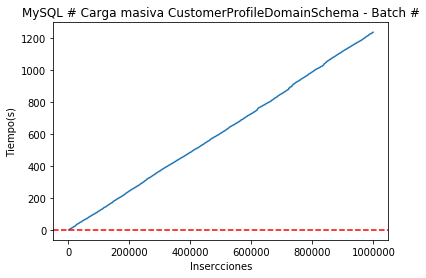

In [26]:
plt.plot(*zip(*registers))
plt.title("MySQL # Carga masiva CustomerProfileDomainSchema - Batch #")
plt.xlabel("Insercciones")
plt.ylabel("Tiempo(s)")
plt.axhline(round(np.average(trx_solo)*100,2), color='r', linestyle='--',label='Media ejecución Trx.')
plt.show()

 _________________________________________________________________

# Batch dominio CurrentAccountDomainSchema Load

In [53]:
CurrentAccount_csv_file = "../MockData/CurrentAccount.csv"
AccountInfo_csv_file = "../MockData/AccountInfo.csv"

In [54]:
CurrentAccount_df = pd.read_csv(CurrentAccount_csv_file, header=[0])
del(CurrentAccount_df['Unnamed: 8'])
CurrentAccount_df['Status'] = CurrentAccount_df['Status'].str.replace("'",'')
CurrentAccount_df['AccountType'] = CurrentAccount_df['AccountType'].str.replace("'",'')
CurrentAccount_df['AccountSubType'] = CurrentAccount_df['AccountSubType'].str.replace("'",'')
CurrentAccount_df.sample(1)

,AccountId,PartyId,Status,StatusUpdateDateTime,AccountType,NickName,OpeningDate,AccountSubType
7102,7103,7103,Enabled,1988-10-21 05:06:14.00,Business,scale cross-platform systems,2004-12-01 14:21:10.00,SAI


In [55]:
AccountInfo_df = pd.read_csv(AccountInfo_csv_file, header=[0])
del(AccountInfo_df['Unnamed: 5'])
AccountInfo_df['SchemeName'] = AccountInfo_df['SchemeName'].str.replace("'",'')
SchemeNameList=['ES.OBIE.SortCodeAccountNumber','UK.OBIE.ExternalccountNumber','ES.OBIE.ExternalAccountNumber']
AccountInfo_df['SchemeName'] = np.resize(SchemeNameList,len(AccountInfo_df))

IdentificationList=['Investment','Money Market','Mortgage','Loan']
AccountInfo_df['Identification'] = np.resize(IdentificationList,len(AccountInfo_df))

AccountInfo_df.sample(5)

,AccountInfoId,AccountId,SchemeName,Identification,Name
2985,2986,2986,ES.OBIE.SortCodeAccountNumber,Money Market,Feeney Ltd
301,302,302,UK.OBIE.ExternalccountNumber,Money Market,"Gerhold, Boyer and Fay"
2660,2661,2661,ES.OBIE.ExternalAccountNumber,Investment,Torphy-Deckow
7450,7451,7451,UK.OBIE.ExternalccountNumber,Mortgage,Steuber-Carter
9215,9216,9216,ES.OBIE.ExternalAccountNumber,Loan,Simonis-Wilderman


In [56]:
#Borramos las tablas para proceder a la carga
cursor = conn.cursor()
cursor.execute('ALTER TABLE CurrentAccountDomainSchema.CurrentAccount AUTO_INCREMENT=0')
cursor.execute('DELETE FROM CurrentAccountDomainSchema.CurrentAccount')
cursor.execute('ALTER TABLE CurrentAccountDomainSchema.CurrentAccount ALTER AccountId SET DEFAULT 0')
cursor.execute('ALTER TABLE CurrentAccountDomainSchema.AccountInfo AUTO_INCREMENT=0')
cursor.execute('DELETE FROM CurrentAccountDomainSchema.AccountInfo')
conn.commit()

OperationalError: MySQL Connection not available.

In [47]:
set_foreing_key_mysql_value(0)
print("Desabilitadas las comprobaciones de foreing key (simulacion batch)")

Desabilitadas las comprobaciones de foreing key (simulacion batch)


In [48]:
#Resultados transaccion batch de CurrentDomainSchema
Total_AccountDomainSchema = []

insert_query_accounts = """INSERT INTO CurrentAccountDomainSchema.CurrentAccount (PartyId, Status, StatusUpdateDateTime, AccountType, NickName, OpeningDate, AccountSubType) VALUES (%s, %s, %s, %s, %s, %s, %s)"""
insert_query_info = """INSERT INTO CurrentAccountDomainSchema.AccountInfo (AccountId, SchemeName, Identification, Name) VALUES (%s, %s, %s, %s)"""

registers = []
trx_solo = []
total_time = 0
Info_inserted = 0
time_inicial = time.time()

for iteracion in range(0,repeats): #1 millones de registros
    for i,row in CurrentAccount_df.iterrows():        
        cursor = conn.cursor()
        #Obtenemos 1 a 3 infoAccounts
        Info_rd_df = AccountInfo_df.sample(random.choice(range(1,3)))               
        #Guardamos el cliente
        trx_inicio = time.time()
        cursor.execute(insert_query_accounts,(row[1],row[2],row[3],row[4],row[5],row[6],row[7]))                                          
        for j,rowInfo in Info_rd_df.iterrows():  
            #Por cada cliente guardamos 1-3 direcciones al azar
            cursor.execute(insert_query_info,(rowInfo[1],rowInfo[2],rowInfo[3],rowInfo[4]))
            Address_inserted = Info_inserted + 1
        trx_parcial = time.time()-trx_inicio
        trx_solo.append(trx_parcial)
        if(i % 1000 == 0 and i > 0):
            conn.commit()        
            # Tupla con numero de registros, tiempo parcial de la transacción y tiempo acumulado de trxs
            total_time = total_time + trx_parcial # Acumulamos el parcial
            registers.append(((i + (len(CurrentAccount_df) * iteracion)),total_time * 1000 ))       
total_time_final = time.time() - time_inicial           
conn.commit() # Final y salida

IntegrityError: 1062 (23000): Duplicate entry '0' for key 'PRIMARY'

In [ ]:
set_foreing_key_mysql_value(1)
print("Habilitadas las comprobaciones de foreing key")

In [ ]:
## Tratamiento de resultados
results_AccountDomainSchema = list(zip(*registers))
print("ROWS INSERTED:", len(CurrentAccount_df) + Address_inserted, ' Total rows')
print("TOTAL TIME:" , round(total_time_final,2), 'seg')
print("MAX:" , round(max(trx_solo)*100,2), 'seg')
print("MIN:" , round(min(trx_solo)*100,2), 'seg')
print("AVG:" , round(np.average(trx_solo)*100,2), 'seg')

In [ ]:
plt.plot(*zip(*registers))
plt.title("MySQL # ETL CurrentAccountDomainSchema")
plt.xlabel("Insercciones")
plt.ylabel("Tiempo(s)")
plt.axhline(np.average(results_AccountDomainSchema[1]), color='r', linestyle='--',label='Media ejecución Trx.')
plt.show()

 _________________________________________________________________

# Batch dominio PositionKeepingDomainSchema Load

In [ ]:
Currency_csv_file = "../MockData/Currency.csv"
PositionKeeping_csv_file = "../MockData/PositionKeeping.csv"
CreditLine_csv_file = "../MockData/CreditLine.csv"
Amount_csv_file = "../MockData/Amount.csv"

In [ ]:
Currency_df = pd.read_csv(Currency_csv_file, header=[0])
del(Currency_df['Unnamed: 3'])
Currency_df.sample(1)

In [ ]:
#Credit line
CreditLine_df = pd.read_csv(CreditLine_csv_file, header=[0])
CreditLine_df.sample(1)

In [ ]:
# Debito (Amount)
Amount_df = pd.read_csv(Amount_csv_file, header=[0])
del(Amount_df['Unnamed: 3'])
Amount_df['Amount'] = Amount_df['Amount'].astype('int')
Amount_df.sample(1)

In [ ]:
PositionKeeping_df = pd.read_csv(PositionKeeping_csv_file, header=[0])
del(PositionKeeping_df['Unnamed: 6'])
PositionKeeping_df['CreditDebitIndicator'] = PositionKeeping_df['CreditDebitIndicator'].str.replace("'",'')
PositionKeeping_df['Type'] = PositionKeeping_df['Type'].str.replace("'",'')
PositionKeeping_df.sample(1)

In [ ]:
del(CreditLine_df['Unnamed: 5'])
CreditLine_df['Type'] = CreditLine_df['Type'].str.replace("'",'')
CreditLine_df.sample(1)

In [ ]:
#Borramos las tablas para proceder a la carga
cursor = conn.cursor()
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.Currency AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.Currency')
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.PositionKeeping AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.PositionKeeping')
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.CreditLine AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.CreditLine')
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.CreditLine ALTER Included SET DEFAULT 0')
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.Amount AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.Amount')
conn.commit()

In [ ]:
set_foreing_key_mysql_value(0)
print("Desabilitadas las comprobaciones de foreing key (simulacion batch)")

In [ ]:
for i,row in Currency_df.iterrows():
    insert_query = "INSERT INTO PositionKeepingDomainSchema.Currency (Code, Description) VALUES (%s, %s)"    
    cursor.execute(insert_query,(row[1],row[2]))

In [ ]:
TotalAccounts = len(CurrentAccount_df) * repeats

In [ ]:
#Completamos tantas position Keeping como cuentas (no se puede repetir id)
for x in range(8):
    PositionKeeping_df = PositionKeeping_df.append(PositionKeeping_df.sample(frac=0.50,replace = False))

len(PositionKeeping_df)

In [ ]:
PositionKeeping_df.index = range(0, len(PositionKeeping_df))
PositionKeeping_df['AccountId'] = range(0, len(PositionKeeping_df))
PositionKeeping_df = PositionKeeping_df[0:TotalAccounts]

In [ ]:
#Resultados transaccion batch de CurrentDomainSchema
Total_PositionKeepingDomainSchema = []

insert_query_creditLine = """INSERT INTO PositionKeepingDomainSchema.CreditLine (CurrencyId, Amount, Type) VALUES (%s, %s, %s)"""
insert_query_amount = """INSERT INTO PositionKeepingDomainSchema.Amount (CurrencyId, Amount) VALUES (%s, %s)"""
insert_query_positionKeeping = """INSERT INTO PositionKeepingDomainSchema.PositionKeeping (AccountId, DateTime, CreditDebitIndicator, Type, AmountId, CreditLineId) VALUES (%s, %s, %s, %s, %s, %s)"""

registers = []
trx_solo = []
total_time = 0
Info_inserted_amount = 0
Info_inserted_creditline = 0
time_inicial = time.time()

for iteracion in range(0,1): #1 millones de registros como fuente origen
    for i,row in PositionKeeping_df.iterrows():        
        cursor = conn.cursor()
        trx_inicio = time.time()
        #Guardamos amount
        for j,rowAM in Amount_df.sample(1).iterrows():
            #print(rowAM)
            cursor.execute(insert_query_amount,(int(rowAM[1]), int(rowAM[2])))
        #Guardamos creditLine
        for h,rowCL in CreditLine_df.sample(1).iterrows():
            #print(rowCL)
            cursor.execute(insert_query_creditLine,(rowCL[1],rowCL[2],rowCL[3]))        
        #Guardamos PositionKeeping
        #print(row)
        cursor.execute(insert_query_positionKeeping,(row[0],row[1],row[2],row[3],row[0],row[0]))                                          
        
        Info_inserted_amount = Info_inserted_amount + 1
        Info_inserted_creditline = Info_inserted_creditline + 1
        
        trx_parcial = time.time()-trx_inicio
        trx_solo.append(trx_parcial)
        if(i % 5 == 0 and i > 0):
            conn.commit()        
            # Tupla con numero de registros, tiempo parcial de la transacción y tiempo acumulado de trxs
            total_time = total_time + trx_parcial # Acumulamos el parcial
            registers.append(((i + (len(PositionKeeping_df) * iteracion)),total_time * 1000 ))       
total_time_final = time.time() - time_inicial           
conn.commit() # Final y salida

In [ ]:
set_foreing_key_mysql_value(1)
print("Habilitadas las comprobaciones de foreing key")

In [ ]:
## Tratamiento de resultados
results_AccountDomainSchema = list(zip(*registers))
print("ROWS INSERTED:", len(PositionKeeping_df) + Info_inserted_amount + Info_inserted_creditline, ' Total rows')
print("TOTAL TIME:" , round(total_time_final,2), 'seg')
print("MAX:" , round(max(trx_solo)*100,2), 'seg')
print("MIN:" , round(min(trx_solo)*100,2), 'seg')
print("AVG:" , round(np.average(trx_solo)*100,2), 'seg')

In [ ]:
plt.plot(*zip(*registers))
plt.title("MySQL # ETL PositionKeeping ETL")
plt.xlabel("Insercciones")
plt.ylabel("Tiempo(s)")
plt.axhline(round(np.average(trx_solo)*100,2), color='r', linestyle='--',label='Media ejecución Trx.')
plt.show()

In [51]:
conn.close()
print('Conexion cerrada')

Conexion cerrada
